In [2]:
import pandas as pd
from scipy.io import arff

# Load ARFF dataset
arff_file_path = r"C:\Users\katta\DISTRIBUTEDPROJECT\dry+bean+dataset\DryBeanDataset\Dry_Bean_Dataset.arff"  # Replace with actual file path
data, meta = arff.loadarff(arff_file_path)

# Convert ARFF to DataFrame and select the first 2000 rows
df = pd.DataFrame(data).head(2000)

# Display the shape of the subset
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")


Dataset loaded with 2000 rows and 17 columns.


In [3]:
import numpy as np
from scipy.spatial.distance import euclidean

# Number of nodes (rows)
num_nodes = df.shape[0]

# Display graph size
print(f"Graph has {num_nodes} nodes (one for each row).")


Graph has 2000 nodes (one for each row).


In [4]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)

# Convert categorical columns to numeric using Label Encoding
label_encoders = {}
for col in non_numeric_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Convert to string before encoding
    label_encoders[col] = le  # Store encoders for reference

# Convert entire dataset to numeric
df_numeric = df.apply(pd.to_numeric, errors='coerce').dropna()
df_numeric.reset_index(drop=True, inplace=True)

print(f"Dataset cleaned: {df_numeric.shape[0]} rows, {df_numeric.shape[1]} columns")


Non-numeric columns: Index(['Class'], dtype='object')
Dataset cleaned: 2000 rows, 17 columns


In [5]:
import numpy as np
from scipy.spatial.distance import euclidean

num_nodes = df_numeric.shape[0]  # Number of rows in the cleaned dataset
graph = np.full((num_nodes, num_nodes), np.inf)  # Adjacency matrix initialized with infinity

# Compute Euclidean distance between nodes (rows)
for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:  # Avoid self-loops
            graph[i][j] = euclidean(df_numeric.iloc[i], df_numeric.iloc[j])

print(f"Graph constructed with {num_nodes} nodes.")


Graph constructed with 2000 nodes.


In [7]:
from mpi4py import MPI
import numpy as np
import pandas as pd
from scipy.io import arff
from scipy.spatial.distance import euclidean
import heapq
import time

# Initialize MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Dataset path
dataset_path = r"C:\Users\katta\DISTRIBUTEDPROJECT\dry+bean+dataset\DryBeanDataset\Dry_Bean_Dataset.arff"

# Root process loads dataset
if rank == 0:
    print("[Process 0] Loading ARFF dataset...")
    
    # Load ARFF dataset
    arff_data, meta = arff.loadarff(dataset_path)
    df = pd.DataFrame(arff_data)

    # Convert categorical columns to numeric
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = pd.factorize(df[col])[0]

    # Normalize data
    df = (df - df.min()) / (df.max() - df.min())

    # Use only first 2000 rows
    df = df.iloc[:2000]

    num_nodes = df.shape[0]
    adjacency_matrix = np.full((num_nodes, num_nodes), np.inf)

    # Construct graph using Euclidean distances
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            dist = euclidean(df.iloc[i], df.iloc[j])
            adjacency_matrix[i][j] = dist
            adjacency_matrix[j][i] = dist  # Ensure symmetric adjacency matrix

    print(f"[Process 0] Graph constructed with {num_nodes} nodes.")
else:
    adjacency_matrix = None
    num_nodes = None

# Broadcast number of nodes to all processes
num_nodes = comm.bcast(num_nodes, root=0)

# **Distribute Adjacency Matrix Efficiently Using Scatterv**
if rank == 0:
    row_counts = np.array_split(np.arange(num_nodes), size)
    send_counts = np.array([len(rows) * num_nodes for rows in row_counts])
    displacements = np.array([sum(send_counts[:i]) for i in range(size)])
else:
    send_counts = None
    displacements = None

# Allocate memory for local chunk
local_size = num_nodes // size + (1 if rank < num_nodes % size else 0)
local_graph = np.empty((local_size, num_nodes), dtype=np.float64)

# Scatter adjacency matrix rows
comm.Scatterv([adjacency_matrix, send_counts, displacements, MPI.DOUBLE], local_graph, root=0)

# ** Optimized Parallel Dijkstra’s Algorithm Using Min-Heap (Priority Queue) **
def dijkstra_parallel(graph, start_node, rank, size, num_nodes):
    local_size = graph.shape[0]
    local_offset = sum(send_counts[:rank]) // num_nodes  # Starting row index

    # Initialize priority queue with local distances
    distances = {node: float('inf') for node in range(local_offset, local_offset + local_size)}
    distances[start_node] = 0 if local_offset <= start_node < local_offset + local_size else float('inf')
    
    min_heap = [(0, start_node)] if start_node in distances else []
    visited = set()

    for _ in range(num_nodes):
        # Find global minimum distance node using priority queue
        if min_heap:
            local_min_distance, local_min_node = heapq.heappop(min_heap)
        else:
            local_min_distance, local_min_node = float('inf'), None

        # Get global minimum node across all processes
        global_min_distance, global_min_node = comm.allreduce((local_min_distance, local_min_node), op=MPI.MINLOC)

        if global_min_node is None:
            break

        visited.add(global_min_node)

        # Update local distances
        for neighbor in range(num_nodes):
            if neighbor not in visited and graph[global_min_node - local_offset][neighbor] != np.inf:
                new_distance = distances[global_min_node] + graph[global_min_node - local_offset][neighbor]
                if new_distance < distances[neighbor]:
                    distances[neighbor] = new_distance
                    heapq.heappush(min_heap, (new_distance, neighbor))

    return distances

# Start timer
start_time = time.time()

# Run optimized parallel Dijkstra algorithm
local_distances = dijkstra_parallel(local_graph, start_node=0, rank=rank, size=size, num_nodes=num_nodes)

# Gather results at root process
all_distances = comm.gather(local_distances, root=0)

# Stop timer
end_time = time.time()

# ** Serial Execution for Comparison (Run only in Process 0) **
if rank == 0:
    def dijkstra_serial(graph, start_node):
        num_nodes = len(graph)
        distances = {node: float('inf') for node in range(num_nodes)}
        distances[start_node] = 0
        min_heap = [(0, start_node)]

        while min_heap:
            min_distance, min_node = heapq.heappop(min_heap)
            
            for neighbor in range(num_nodes):
                if graph[min_node][neighbor] != np.inf:
                    new_distance = min_distance + graph[min_node][neighbor]
                    if new_distance < distances[neighbor]:
                        distances[neighbor] = new_distance
                        heapq.heappush(min_heap, (new_distance, neighbor))
        
        return distances

    print("\n[Process 0] Running Serial Dijkstra Algorithm...")
    serial_start_time = time.time()
    serial_distances = dijkstra_serial(adjacency_matrix, start_node=0)
    serial_end_time = time.time()

    serial_execution_time = serial_end_time - serial_start_time
    print(f"\nSerial Execution Time: {serial_execution_time:.4f} seconds")

# Print results at root process
if rank == 0:
    final_distances = {}
    for partial_result in all_distances:
        final_distances.update(partial_result)

    print("\nFinal Shortest Paths from Node 0:")
    for node, dist in sorted(final_distances.items()):
        print(f"Node {node}: {dist:.4f}")

    parallel_execution_time = end_time - start_time
    print(f"\nParallel Execution Time: {parallel_execution_time:.4f} seconds")

    # Speedup calculation
    if serial_execution_time > 0:
        speedup = serial_execution_time / parallel_execution_time
        print(f"\nSpeedup Achieved: {speedup:.2f}x")


[Process 0] Loading ARFF dataset...
[Process 0] Graph constructed with 2000 nodes.

[Process 0] Running Serial Dijkstra Algorithm...

Serial Execution Time: 2.7380 seconds

Final Shortest Paths from Node 0:
Node 0: 0.0000
Node 1: 0.3531
Node 2: 0.0700
Node 3: 0.2514
Node 4: 0.4610
Node 5: 0.0972
Node 6: 0.2669
Node 7: 0.1020
Node 8: 0.1038
Node 9: 0.1017
Node 10: 0.1277
Node 11: 0.2492
Node 12: 0.1204
Node 13: 0.1434
Node 14: 0.2019
Node 15: 0.1680
Node 16: 0.1170
Node 17: 0.1137
Node 18: 0.1955
Node 19: 0.1102
Node 20: 0.1122
Node 21: 0.1889
Node 22: 0.2316
Node 23: 0.3060
Node 24: 0.4658
Node 25: 0.3283
Node 26: 0.1680
Node 27: 0.1072
Node 28: 0.1166
Node 29: 0.1645
Node 30: 0.2213
Node 31: 0.1700
Node 32: 0.1945
Node 33: 0.1664
Node 34: 0.2418
Node 35: 0.2706
Node 36: 0.3057
Node 37: 0.2687
Node 38: 0.3031
Node 39: 0.1563
Node 40: 0.1777
Node 41: 0.1938
Node 42: 0.4366
Node 43: 0.1746
Node 44: 0.1203
Node 45: 0.1429
Node 46: 0.1170
Node 47: 0.1208
Node 48: 0.1508
Node 49: 0.1180
Nod

In [8]:
if rank == 0:
    print("\n[Validation] Comparing Parallel and Serial Results...")

    # Convert results to consistent format for validation
    serial_results = np.array([serial_distances[node] for node in range(num_nodes)])
    parallel_results = np.array([final_distances.get(node, float('inf')) for node in range(num_nodes)])

    # Check if results are numerically close
    is_valid = np.allclose(serial_results, parallel_results, atol=1e-6)

    if is_valid:
        print("[Validation]  PASS: Parallel and Serial results match.")
    else:
        print("[Validation]  FAIL: Parallel and Serial results do not match!")

    # Identify incorrect nodes if validation fails
    if not is_valid:
        incorrect_nodes = [node for node in range(num_nodes) if not np.isclose(serial_results[node], parallel_results[node], atol=1e-6)]
        print("[Validation] Mismatch found at nodes:", incorrect_nodes)

    # Speedup check
    print(f"\nSerial Execution Time: {serial_execution_time:.4f} seconds")
    print(f"Parallel Execution Time: {parallel_execution_time:.4f} seconds")

    if serial_execution_time > 0:
        speedup = serial_execution_time / parallel_execution_time
        print(f"Speedup Achieved: {speedup:.2f}x")



[Validation] Comparing Parallel and Serial Results...
[Validation]  PASS: Parallel and Serial results match.

Serial Execution Time: 2.7380 seconds
Parallel Execution Time: 1.9292 seconds
Speedup Achieved: 1.42x


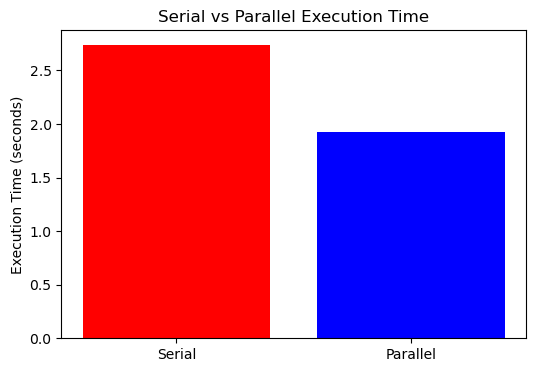

In [9]:
import matplotlib.pyplot as plt

if rank == 0:
    plt.figure(figsize=(6, 4))
    plt.bar(["Serial", "Parallel"], [serial_execution_time, parallel_execution_time], color=['red', 'blue'])
    plt.ylabel("Execution Time (seconds)")
    plt.title("Serial vs Parallel Execution Time")
    plt.show()


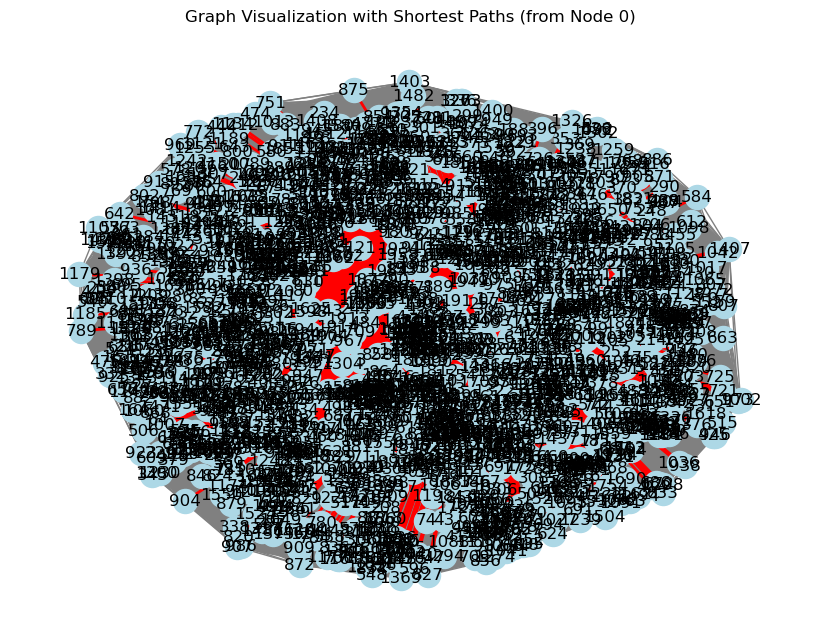

In [10]:
import networkx as nx

if rank == 0:
    G = nx.Graph()

    # Add nodes
    for node in range(num_nodes):
        G.add_node(node)

    # Add edges with weights
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if adjacency_matrix[i][j] != np.inf:
                G.add_edge(i, j, weight=round(adjacency_matrix[i][j], 2))

    # Draw Graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  # Layout for better visualization
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')

    # Highlight shortest paths from Node 0
    shortest_paths = [(0, node) for node in final_distances if node != 0]
    nx.draw_networkx_edges(G, pos, edgelist=shortest_paths, edge_color='red', width=2)

    plt.title("Graph Visualization with Shortest Paths (from Node 0)")
    plt.show()
